## MIE 1622 Computational Finance and Risk Management

### Assignment 1 - Mean Variance Portfolio Selection

1. The purpose of the assignment is to compare the investment strategies based on mean variance portfolio optimization taking into account the effect of trading cost. 
2. The dataset used for this consists of stock prices of 20 companies at the closing of each trading day for a span of two years from 2015 to 2016. 
3. Considering four different strategies,namely "Buy and Hold", "Equally weighted", "Minimum variance", "Maximum sharp ratio", our aim is to compute the portfolio value to provide an informed decision on selecting the best strategy.

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import math
import cplex
import matplotlib.pyplot as plt
%matplotlib inline

### Minimum variance portfolio:
In this method, the below optimization problem is solved for the optimal weights of the portfolio
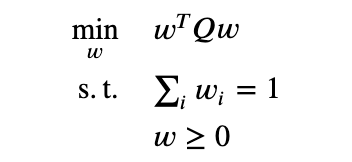

## Maximum sharp ratio:
In this method, the below optimization problem is solved for the optimal weights of the portfolio using sharp ratio fundamental. 
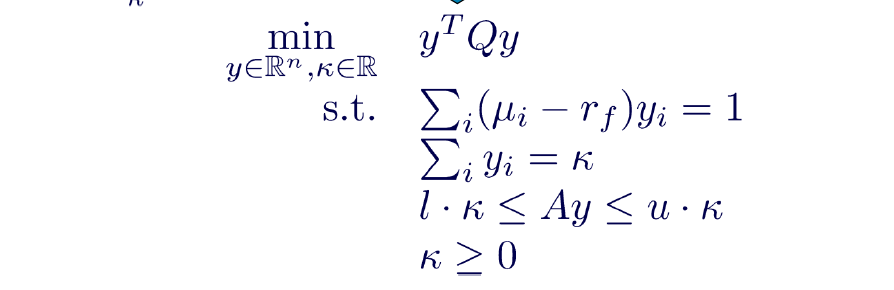

In [2]:
def rounding_strategy(cash,x_init, x_opt, cur_prices,p_value):
    #If cash is negative, we reduce 1 share from entity that has least share price
    if cash<0:
        for i in range(len(x_init)):
            if x_opt[np.argsort(cur_prices)[i]]==0:
                continue
            
            #If the entity with least price has 0 shares, we move on to the next least one
            while x_opt[np.argsort(cur_prices)[i]]>0:
                x_opt[np.argsort(cur_prices)[i]]-=1
                
                #caluclating the transaction cost and cash based on the adjusted position
                transaction_cost=np.sum(abs(x_opt-x_init)*0.005*cur_prices)
                cash=p_value-np.sum(x_opt*cur_prices)-transaction_cost
                
                #Continue the loop till the cash is positive
                if cash>=0:
                    break
                    
            if cash>=0:
                break
    return(x_opt,cash)

In [3]:
# Complete the following functions
def strat_buy_and_hold(x_init, cash_init, mu, Q, cur_prices):
    
    #No trading is done in this strategy, so position is same throughout the cycle
    x_optimal = x_init
    cash_optimal = cash_init
    return x_optimal, cash_optimal

def strat_equally_weighted(x_init, cash_init, mu, Q, cur_prices):
    
    #Caluclating initial portfolio value
    p_value = sum(x_init*cur_prices)+cash_init
    
    #Dividing the available value equally
    price_per_company=p_value/(len(x_init))
    
    #Calculate number of shares and rounding up
    x_opt=x_optimal=np.ceil(price_per_company/cur_prices)
    transaction_cost = np.dot(np.abs(x_opt-x_init),cur_prices)*0.005
    
    #Net cash after deducting transaction cost from portfolio value
    cash=p_value-sum(x_opt*cur_prices)-transaction_cost
    
    #Validating the cash to be non-negative and number of shares are integers
    x_optimal,cash_optimal=rounding_strategy(cash,x_init,x_opt,cur_prices,p_value)

    return x_optimal, cash_optimal

def strat_min_variance(x_init, cash_init, mu, Q, cur_prices):
    
    #Caluclating initial portfolio value
    p_value=np.sum(x_init*cur_prices)+cash_init
    
    #Setting minimize/maximize model from cplex
    cpx = cplex.Cplex()
    cpx.objective.set_sense(cpx.objective.sense.minimize)
    
    #Defining the linear component of problem and variable boundaries
    n=len(x_init)
    c  = [0.0] * n
    lb = [0.0] * n
    ub = [1.0] * n
    
    #Defining linear constraints
    A = []
    for k in range(n):
        A.append([[0],[1.0]])
    var_names = ["w_%s" % i for i in range(1,n+1)]
    cpx.linear_constraints.add(rhs=[1.0], senses="E")
    
    #Formulating the objective function and constraints
    cpx.variables.add(obj=c, lb=lb, ub=ub, columns=A, names=var_names)
    
    #Defining quadratic part of the objective function
    Qmat = [[list(range(n)), list(2*Q[k,:])] for k in range(n)]
    cpx.objective.set_quadratic(Qmat)
    
    alg = cpx.parameters.lpmethod.values
    cpx.parameters.qpmethod.set(alg.concurrent)
    cpx.parameters.threads.set(4)
    
    # Disable CPLEX output to screen
    cpx.set_results_stream(None)
    cpx.set_warning_stream(None)
    
    #Solving the optimization problem
    cpx.solve()
    
    w_opt = np.array(cpx.solution.get_values())
    
    #Calculating the positions based on the weights ratio obtained and rounding the number of shares
    x_opt=np.round(w_opt*p_value/cur_prices)
    
    transaction_cost = np.dot(np.abs(x_opt-x_init),cur_prices)*0.005
    
    #Net cash after deducting transaction cost from portfolio value
    cash=p_value-sum(x_opt*cur_prices)-transaction_cost
    
    #Validating the cash to be non-negative and number of shares are integers
    x_optimal,cash_optimal=rounding_strategy(cash,x_init,x_opt,cur_prices,p_value)
    
#     print(x_optimal)
    return x_optimal, cash_optimal

def strat_max_Sharpe(x_init, cash_init, mu, Q, cur_prices):
    
    #Caluclating initial portfolio value
    p_value=np.sum(x_init*cur_prices)+cash_init
    
    #Setting minimize/maximize model from cplex
    cpx = cplex.Cplex()
    cpx.objective.set_sense(cpx.objective.sense.minimize)
    
    #Defining the linear component of problem and variable boundaries
    n=len(x_init)
    c  = [0.0] * (n+1)
    lb = [0.0] * (n+1)
    ub = [np.inf] * (n+1)
    
    #Convert the annual risk free rate to daily (Considering 252 trading days)
    r_rf=0.025/252

    #Defining linear constraints coefficients
    A = []
    for k in range(n):
        A.append([[0,1],[mu[k]-r_rf,1]])
        
    #Additional entity to be appended as there is extra variable 'k'
    A.append([[0,1],[0,-1]])    
    
    var_names = ["w_%s" % i for i in range(1,n+1)]
    var_names.append('k')
    
    #Defining linear constraints bounds and equality
    cpx.linear_constraints.add(rhs=[1.0,0], senses="EE")
    
    #Formulating the objective function and constraints
    cpx.variables.add(obj=c, lb=lb, ub=ub, columns=A, names=var_names)
    
    #Defining quadratic part of the objective function (Adding extra row and column of zeroes that corresponds to k)
    Qmat = [[list(range(n+1)), list(2*np.append(Q[k,:],0))] for k in range(n)]
    Qmat.append([list(range(n+1)),[0]*(len(Qmat)+1)])
    cpx.objective.set_quadratic(Qmat)
    
    cpx.parameters.threads.set(4)
    
    # Disable CPLEX output to screen
    cpx.set_results_stream(None)
    cpx.set_warning_stream(None)
    
    #Solving the optimization problem
    cpx.solve()
    
    #Calculating weights from 'y' (w=y/k) k is the 21st result of the solver
    w_opt = np.array(cpx.solution.get_values()[0:20])/cpx.solution.get_values()[20]
    
    #Calculating the positions, transaction costs based on the weights ratio obtained and rounding the number of shares
    x_opt=np.round(w_opt*p_value/cur_prices)
    transaction_cost=np.sum(np.abs(x_opt-x_init)*0.005*cur_prices)
    
    #Net cash after deducting transaction cost from portfolio value
    cash=p_value-sum(x_opt*cur_prices)-transaction_cost
    
    #Validating the cash to be non-negative and number of shares are integers
    x_optimal,cash_optimal=rounding_strategy(cash,x_init,x_opt,cur_prices,p_value)
    
#     print(x_optimal)
    return x_optimal, cash_optimal

def strat_equally_weighted_hold(x_init, cash_init, mu, Q, cur_prices):
    
    if(cash_init==0):
        #Caluclating initial portfolio value
        p_value = sum(x_init*cur_prices)+cash_init

        #Dividing the available value equally
        price_per_company=p_value/(len(x_init))

        #Calculate number of shares and rounding up
        x_opt=x_optimal=np.ceil(price_per_company/cur_prices)
        transaction_cost = np.dot(np.abs(x_opt-x_init),cur_prices)*0.005

        #Net cash after deducting transaction cost from portfolio value
        cash=p_value-sum(x_opt*cur_prices)-transaction_cost

        #Validating the cash to be non-negative and number of shares are integers
        x_optimal,cash_optimal=rounding_strategy(cash,x_init,x_opt,cur_prices,p_value)
    else:
        
        #No trading is done in this strategy, so position is same throughout the cycle
        x_optimal = x_init
        cash_optimal = cash_init
        
#     print(x_optimal)
    return x_optimal, cash_optimal

In [4]:
# Input file
input_file_prices = 'Daily_closing_prices.csv'

# Read data into a dataframe
df = pd.read_csv(input_file_prices)

In [5]:
# Convert dates into array [year month day]
def convert_date_to_array(datestr):
    temp = [int(x) for x in datestr.split('/')]
    return [temp[-1], temp[0], temp[1]]

dates_array = np.array(list(df['Date'].apply(convert_date_to_array)))
data_prices = df.iloc[:, 1:].to_numpy()
dates = np.array(df['Date'])
day_ind_start0 = 0
day_ind_end0 = len(np.where(dates_array[:,0]==2014)[0])

In [6]:
# Find the number of trading days in Nov-Dec 2014 and
# compute expected return and covariance matrix for period 1
day_ind_start0 = 0
day_ind_end0 = len(np.where(dates_array[:,0]==2014)[0])
cur_returns0 = data_prices[day_ind_start0+1:day_ind_end0,:] / data_prices[day_ind_start0:day_ind_end0-1,:] - 1
mu = np.mean(cur_returns0, axis = 0)
Q = np.cov(cur_returns0.T)

# Remove datapoints for year 2014
data_prices = data_prices[day_ind_end0:,:]
dates_array = dates_array[day_ind_end0:,:]
dates = dates[day_ind_end0:]

In [7]:
# Initial positions in the portfolio
init_positions = np.array([5000, 950, 2000, 0, 0, 0, 0, 2000, 3000, 1500, 0, 0, 0, 0, 0, 0, 1001, 0, 0, 0])

# Initial value of the portfolio
init_value = np.dot(data_prices[0,:], init_positions)
print('\nInitial portfolio value = $ {}\n'.format(round(init_value, 2)))

# Initial portfolio weights
w_init = (data_prices[0,:] * init_positions) / init_value


Initial portfolio value = $ 1000002.12



In [8]:
# Number of periods, assets, trading days
N_periods = 6*len(np.unique(dates_array[:,0])) # 6 periods per year
N = len(df.columns)-1
N_days = len(dates)

# Annual risk-free rate for years 2015-2016 is 2.5%
r_rf = 0.025

# Number of strategies
strategy_functions = ['strat_buy_and_hold', 'strat_equally_weighted', 'strat_min_variance', 'strat_max_Sharpe','strat_equally_weighted_hold']
strategy_names     = ['Buy and Hold', 'Equally Weighted Portfolio', 'Mininum Variance Portfolio', 'Maximum Sharpe Ratio Portfolio','Equally weighted and hold']
N_strat = 5  # comment this in your code
#N_strat = len(strategy_functions)  # uncomment this in your code
fh_array = [strat_buy_and_hold, strat_equally_weighted, strat_min_variance, strat_max_Sharpe,strat_equally_weighted_hold]

portf_value = [0] * N_strat
x = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
w = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
cash = np.zeros((N_strat, N_periods),  dtype=np.ndarray)


for period in range(1, N_periods+1):
   # Compute current year and month, first and last day of the period
    if dates_array[0, 0] == 15:
        cur_year  = 15 + math.floor(period/7)
    else:
        cur_year  = 2015 + math.floor(period/7)

    cur_month = 2*((period-1)%6) + 1
    day_ind_start = min([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month)) if val])
    day_ind_end = max([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month+1)) if val])
    print('\nPeriod {0}: start date {1}, end date {2}'.format(period, dates[day_ind_start], dates[day_ind_end]))
   
    # Prices for the current day
    cur_prices = data_prices[day_ind_start,:]

    # Execute portfolio selection strategies
    for strategy  in range(N_strat):

      # Get current portfolio positions
        if period == 1:
            curr_positions = init_positions
            curr_cash = 0
            portf_value[strategy] = np.zeros((N_days, 1))
        else:
            curr_positions = x[strategy, period-2]
            curr_cash = cash[strategy, period-2]

      # Compute strategy
        x[strategy, period-1], cash[strategy, period-1] = fh_array[strategy](curr_positions, curr_cash, mu, Q, cur_prices)
        
        #Verifying the rounding function and validating the cash is non-negative
        if cash[strategy, period-1]<0:
            for i in range(len(curr_positions)):
                if x[strategy, period-1][np.argsort(cur_prices)[i]]==0:
                    continue

                #If the entity with least price has 0 shares, we move on to the next least one
                while x[strategy, period-1][np.argsort(cur_prices)[i]]>0:
                    x[strategy, period-1][np.argsort(cur_prices)[i]]-=1

                    #caluclating the transaction cost and cash based on the adjusted position
                    transaction_cost=np.sum(abs(x[strategy, period-1]-curr_positions)*0.005*cur_prices)
                    cash[strategy, period-1]=sum(curr_positions*cur_prices)-np.sum(x[strategy, period-1]*cur_prices)-transaction_cost

                    #Continue the loop till the cash is positive
                    if cash[strategy, period-1]>=0:
                        break

                if cash[strategy, period-1]>=0:
                    break

      # Compute portfolio value
        p_values = np.dot(data_prices[day_ind_start:day_ind_end+1,:], x[strategy, period-1]) + cash[strategy, period-1]
        portf_value[strategy][day_ind_start:day_ind_end+1] = np.reshape(p_values, (p_values.size,1))
        
     #  Computing the weights of asset in the total portfolio
        w[strategy, period-1]=cur_prices*x[strategy, period-1]/sum(cur_prices*x[strategy, period-1])
        
        print('  Strategy "{0}", value begin = $ {1:.2f}, value end = $ {2:.2f}'.format( strategy_names[strategy], 
             portf_value[strategy][day_ind_start][0], portf_value[strategy][day_ind_end][0]))

      
   # Compute expected returns and covariances for the next period
    cur_returns = data_prices[day_ind_start+1:day_ind_end+1,:] / data_prices[day_ind_start:day_ind_end,:] - 1
    mu = np.mean(cur_returns, axis = 0)
    Q = np.cov(cur_returns.T)



Period 1: start date 1/2/2015, end date 2/27/2015
  Strategy "Buy and Hold", value begin = $ 1000002.12, value end = $ 1043785.08
  Strategy "Equally Weighted Portfolio", value begin = $ 992887.17, value end = $ 1019430.17
  Strategy "Mininum Variance Portfolio", value begin = $ 991452.12, value end = $ 1015638.44
  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 990051.93, value end = $ 1009429.26
  Strategy "Equally weighted and hold", value begin = $ 992887.17, value end = $ 1019430.17

Period 2: start date 3/2/2015, end date 4/30/2015
  Strategy "Buy and Hold", value begin = $ 1045234.09, value end = $ 1069877.19
  Strategy "Equally Weighted Portfolio", value begin = $ 1030017.14, value end = $ 1010932.83
  Strategy "Mininum Variance Portfolio", value begin = $ 1022751.20, value end = $ 1015105.70
  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 1019047.83, value end = $ 1058700.83
  Strategy "Equally weighted and hold", value begin = $ 1030515.55, value end

In [9]:
#Verifying the cash in cash account is minimal for each rebalancing period
cash_account=pd.DataFrame(cash,columns=(range(1,13)))
cash_account.index=strategy_functions
cash_account

,1,2,3,4,5,6,7,8,9,10,11,12
strat_buy_and_hold,0,0,0,0,0,0,0,0,0,0,0,0
strat_equally_weighted,1.89373,1.42002,1.08312,1.95909,0.587929,0.713991,2.37916,1.6761,2.09042,4.98453,6.08639,3.19806
strat_min_variance,0.7188,0.617847,0.478259,2.44083,1.1324,1.20697,22.227,19.7898,9.72416,9.07647,13.8177,3.10795
strat_max_Sharpe,17.0175,23.3264,9.701,1.20809,3.39437,0.383688,0.614597,11.7711,2.5044,4.66375,2.30019,10.7502
strat_equally_weighted_hold,1.89373,1.89373,1.89373,1.89373,1.89373,1.89373,1.89373,1.89373,1.89373,1.89373,1.89373,1.89373


In [10]:
#Converting the lists of portfolio values to dataframe for better visualization
results = pd.DataFrame({'Buy and Hold': portf_value[0].flatten(), 
                        'Equally weighted': portf_value[1].flatten(),
                        'Minimum Variance':portf_value[2].flatten(),
                        'Maximum Sharp ratio':portf_value[3].flatten(),
                        'Equally weighted hold':portf_value[4].flatten()})

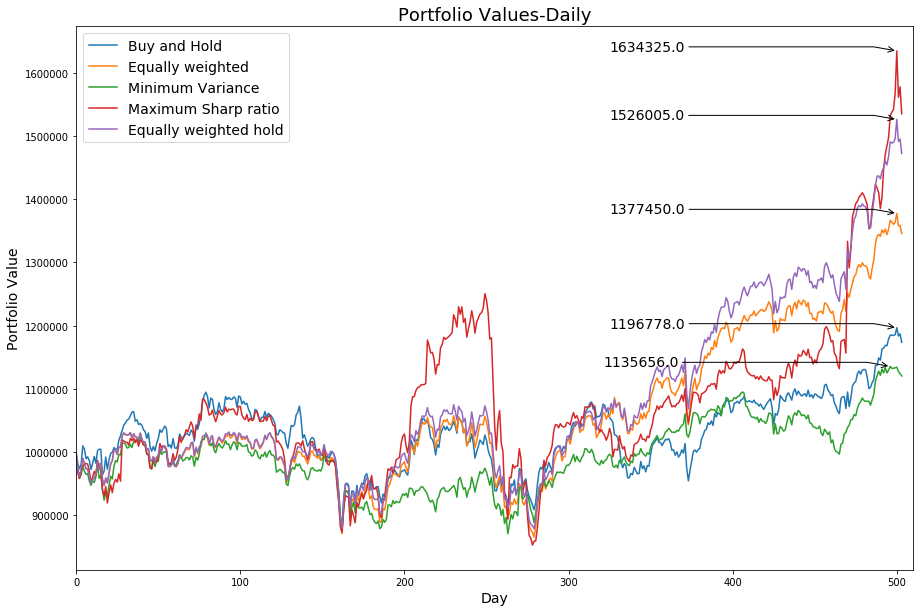

In [11]:
#Plotting the daily portfolio values of all the strategies
results.plot(figsize=(15,10),xlim=[0,510])
plt.title("Portfolio Values-Daily",fontsize=18)
plt.xlabel('Day',fontsize=14)
plt.ylabel('Portfolio Value',fontsize=14)

for i in range(len(results.columns)):
    ymax = results.max()[i]
    xpos = results.idxmax()[i]
    plt.annotate(round(ymax), xy=(xpos, ymax), xytext=(xpos-175, ymax+100),
            arrowprops=dict(arrowstyle="->",connectionstyle="angle,angleA=0,angleB=-10",facecolor='black'),fontsize=14)
plt.legend(fontsize=14)
plt.show()


In [12]:
colors=["black","rosybrown","sienna","gold","olivedrab","darkcyan","navy","darkorchid","pink","indigo",
       "orange","c","coral","peru","dimgrey","greenyellow","dodgerblue","thistle","olive","y"]

In [13]:
#Getting the weights of assests for every rebalancing periods for minimum variance strategy
companies=[]
for i in range(len(w[2][0])):
    for j in range(len(w[2])):
        companies.append(w[2][j][i])

In [14]:
#Forming a dataframe of the assest weights for each period to a dataframe
weights_minvar=[]
for i in range(20):
    weights_minvar.append(companies[i*12:(i*12)+12])
weights_minvar=pd.DataFrame(weights_minvar,columns=range(1,13))
weights_minvar=weights_minvar.T
weights_minvar["sum"]=[sum(weights_minvar.loc[i]) for i in weights_minvar.index]

In [15]:
#Verifying the sum of weights = 1
weights_minvar.head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,sum
1,0.04721,0.00000,0.000000,0.110856,0.000000,0.000000,0.005839,0.195191,0.000000,0.000000,...,0.151605,0.000000,0.000000,0.051965,0.000000,0.000000,0.020227,0.0,0.417107,1.0
2,0.00000,0.00000,0.029301,0.152646,0.000000,0.006857,0.000000,0.179790,0.086081,0.060567,...,0.000000,0.000000,0.000000,0.017987,0.051836,0.000000,0.000000,0.0,0.000000,1.0
3,0.00000,0.00000,0.000000,0.047396,0.000000,0.150542,0.000000,0.420768,0.005107,0.000000,...,0.000000,0.261442,0.032921,0.000000,0.000000,0.054979,0.000000,0.0,0.015021,1.0
4,0.00000,0.08826,0.033147,0.000000,0.005370,0.000000,0.045433,0.425751,0.000000,0.064917,...,0.007421,0.017167,0.000000,0.000000,0.000000,0.063066,0.000000,0.0,0.201579,1.0
5,0.00000,0.00000,0.000000,0.000000,0.055524,0.030296,0.000000,0.278010,0.000000,0.000000,...,0.000000,0.000000,0.028493,0.002768,0.000000,0.000000,0.000000,0.0,0.000000,1.0


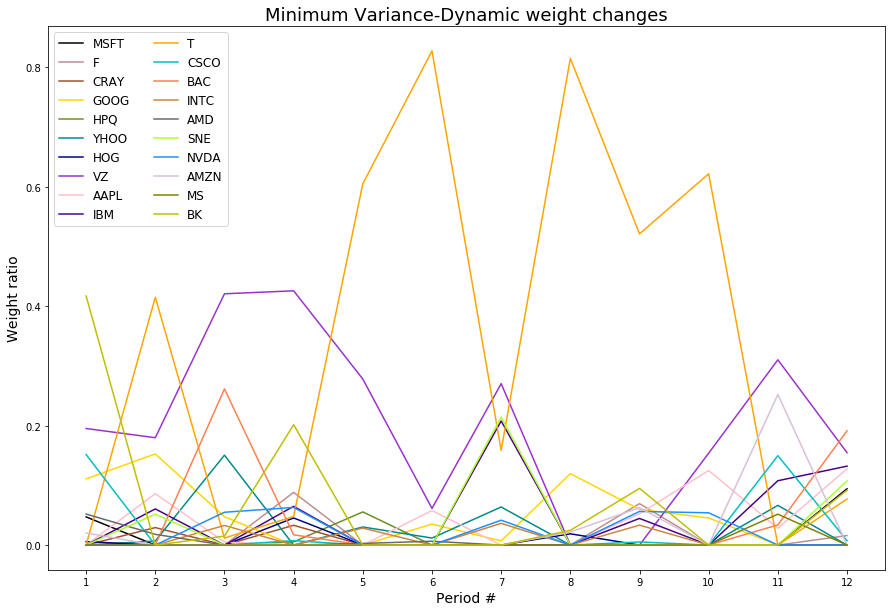

In [16]:
#Dynamic plot of weights of individual assets in the optimized portfolio for minimum variance strategy
titles=df.columns[1:]

plt.figure(figsize=(15,10))

for i in range(20):
    plt.plot(companies[i*12:(i*12)+12],label=titles[i],color=colors[i])

plt.title("Minimum Variance-Dynamic weight changes",fontsize=18)
plt.xlabel("Period #",fontsize=14)
plt.ylabel("Weight ratio",fontsize=14)
plt.xticks(range(0,12),range(1,13))
plt.legend(fontsize=12,ncol=2)
plt.show()

In [17]:
#Duplicating the data for exploratory analysis
df_eda=df.copy(deep=True)
df_eda=df_eda.drop(["Date"],axis=1)
df_eda=df_eda.drop(range(0,41))

In [18]:
index_=[42*i-1 for i in range(13)]
index_[0]=0
index_

[0, 41, 83, 125, 167, 209, 251, 293, 335, 377, 419, 461, 503]

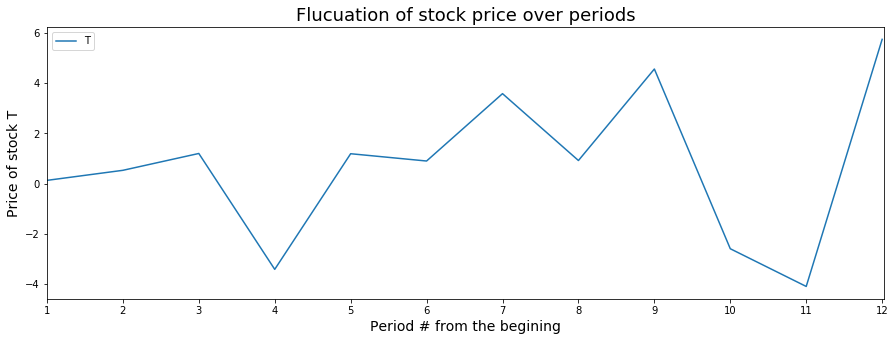

In [19]:
#Dropping the entries of 2014 from the data
dfeda=df_eda.copy(deep=True)
dfeda=dfeda.reset_index()
dfeda=dfeda.drop(["index"],axis=1)

dfeda[["T"]].iloc[index_].diff().plot(figsize=(15,5))
plt.title("Flucuation of stock price over periods",fontsize=18)
plt.xlabel("Period # from the begining",fontsize=14)
plt.ylabel("Price of stock T",fontsize=14)
plt.xticks(index_,range(13))
plt.xlim(41,504)
plt.show()

In [20]:
#Getting the weights of assests for every rebalancing periods for maximum sharp ratio strategy
companies_sharp=[]
for i in range(len(w[3][0])):
    for j in range(len(w[3])):
        companies_sharp.append(w[3][j][i])

In [21]:
#Forming a dataframe of the assest weights for each period to a dataframe
weights_maxsharp=[]
for i in range(20):
    weights_maxsharp.append(companies_sharp[i*12:(i*12)+12])
weights_maxsharp=pd.DataFrame(weights_maxsharp,columns=range(1,13))
weights_maxsharp=weights_maxsharp.T
weights_maxsharp["sum"]=[sum(round(weights_maxsharp.loc[i],3)) for i in weights_maxsharp.index]

In [22]:
#Verifying the sum of weights = 1
weights_maxsharp.head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,sum
1,0.000000,0.0,0.000000,0.000000,0.029865,0.0,0.0,0.000000,0.000000,0.000000,...,0.670788,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.299347,0.000000,1.000
2,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.386235,0.173172,0.000000,...,0.000000,0.00000,0.0,0.000000,0.254391,0.000000,0.186202,0.000000,0.000000,0.999
3,0.264848,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.055218,...,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.011570,0.000000,0.668364,1.000
4,0.000000,0.0,0.072941,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.54261,0.0,0.058899,0.000000,0.000000,0.000000,0.000000,0.000000,1.001
5,0.000000,0.0,0.000000,0.292954,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.0,0.000000,0.000000,0.160243,0.546803,0.000000,0.000000,1.000


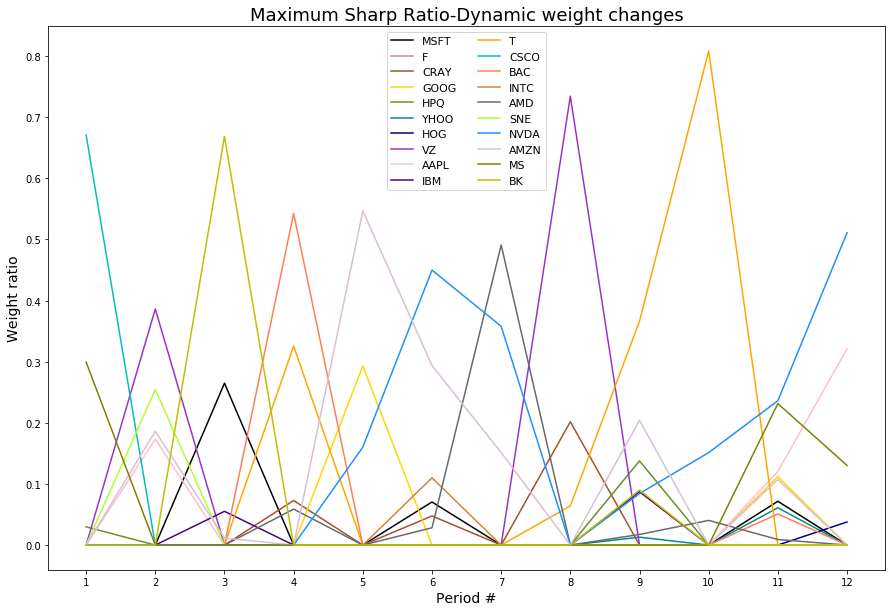

In [23]:
#Dynamic plot of weights of individual assets in the optimized portfolio for maximum sharp ratio strategy
plt.figure(figsize=(15,10))

for i in range(20):
    plt.plot(companies_sharp[i*12:(i*12)+12],label=titles[i],color=colors[i])

plt.title("Maximum Sharp Ratio-Dynamic weight changes",fontsize=18)
plt.xlabel("Period #",fontsize=14)
plt.ylabel("Weight ratio",fontsize=14)
plt.xticks(range(0,12),range(1,13))
plt.legend(ncol=2,fontsize=11)
plt.show()

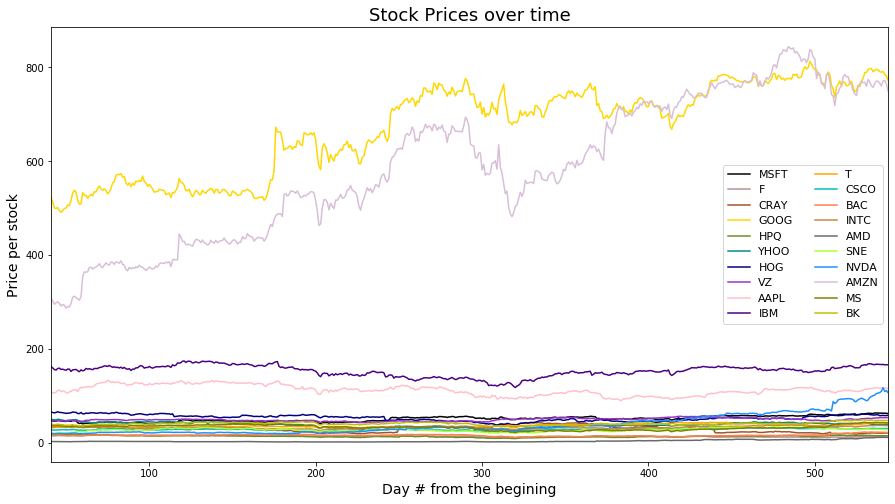

In [24]:
#Stock prices senses over time
df_eda.plot(figsize=(15,8),color=colors)
plt.title("Stock Prices over time",fontsize=18)
plt.xlabel("Day # from the begining",fontsize=14)
plt.ylabel("Price per stock",fontsize=14)
plt.legend(ncol=2,fontsize=11)
plt.show()

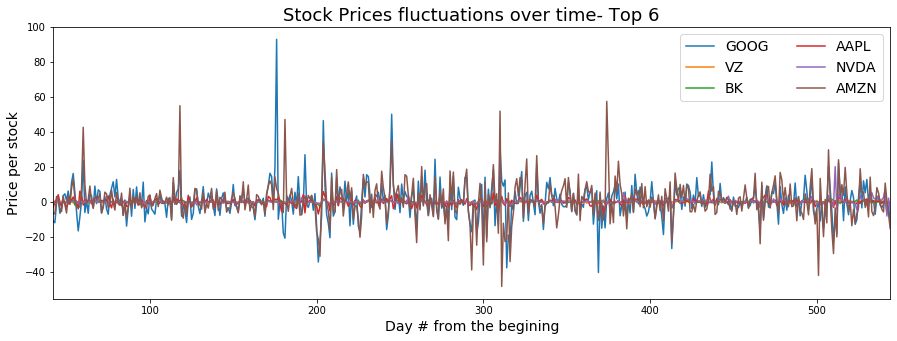

In [25]:
#Difference of the stock prices compared to previous day
df_eda.diff()[["GOOG","VZ","BK","AAPL","NVDA","AMZN"]].iloc[1:].plot(figsize=(15,5))
plt.title("Stock Prices fluctuations over time- Top 6",fontsize=18)
plt.xlabel("Day # from the begining",fontsize=14)
plt.ylabel("Price per stock",fontsize=14)
plt.legend(fontsize=14,ncol=2)
plt.show()

In [26]:
#Percentage change of the share values from begining to ending of the analysis period
per_change=df_eda.diff(periods=503).iloc[503]/df_eda.iloc[41]*100
per_change

MSFT     35.717605
F       -20.149718
CRAY    -42.004690
GOOG     43.449956
HPQ     -22.118515
YHOO    -26.142304
HOG     -11.855508
VZ       13.083354
AAPL      5.049011
IBM       2.465191
T        25.470588
CSCO      8.898732
BAC      26.515152
INTC     -0.263778
AMD     284.262295
SNE      26.783802
NVDA    386.134637
AMZN    115.319295
MS       10.088347
BK       17.545644
dtype: float64

In [27]:
print("% increase in portfolio values are:\n{}".format(round(((results.max()-init_value)/init_value*100),2)))

% increase in portfolio values are:
Buy and Hold             19.68
Equally weighted         37.74
Minimum Variance         13.57
Maximum Sharp ratio      63.43
Equally weighted hold    52.60
dtype: float64


## Discussion
1. Based on the results and discussion so far, it can be clearly understood that a risk averse person who is content with the little returns instead of losing the investment prefer minimum variance strategy.
2. A bold and risk taking investor would definitely prefer to choose the one which yields maximum returns even if it is accompanied by a portion of risk. Hence their option would be maximum sharp strategy.
3. An individual who is not much aware of the markets would blindly go for equally weighted portfolio strategy and rebalances to equal weights to each company at every period. Fortunately, the returns in this strategy is not so worse as the risk is distributed among the entities of the portfolio.
4. Not being a trading friendly person, I opt equally weighted strategy so that I can get good returns by diversifying the risk of losing any money. Also it is easy to form such portfolio without making any mistakes in estimated returns.